In [1]:
import torch
from torch import optim, nn, utils, Tensor
import lightning as L

import numpy as np
import matplotlib.pyplot as plt

from Network import Generator, Discriminator
from Signal_Generator import *
from Signal_Analyzer import *

from getdist import plots, MCSamples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset = []

for i in range(16000):
    SG = Signal_Generator(num_sources=1, noise_amplitude=0)
    signals = SG.generating_signal()
    params = SG.printing_parameters()
    signal = signals['Signal'].values

    signal_tensor = torch.tensor(signal, dtype=torch.float).unsqueeze(0).to(device)
    params_tensor = torch.tensor(params, dtype=torch.float).to(device)

    dataset.append((signal_tensor, params_tensor))

train_loader = utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

num_latent_variables = 20
learning_rate = 1e-5

In [ ]:
class GAN():
    def __init__(self, dataset, num_latent_variables, lr):
        self.dataset = dataset
        self.num_latent_variables = num_latent_variables
        self.lr = lr

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)
        self.criterion = nn.BCELoss()

        # Optimizers
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def adversarial_loss(self, output_d, y):
        return self.criterion(output_d, y)
    
    def train_generator(self, signal_tensor, z):
        generated_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, generated_params)
        g_loss = self.adversarial_loss(fake_output, torch.ones_like(fake_output))

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z).detach()
        real_output = self.discriminator(signal_tensor, params_tensor)
        fake_output = self.discriminator(signal_tensor, fake_params)

        real_loss = self.adversarial_loss(real_output, torch.ones_like(real_output))
        fake_loss = self.adversarial_loss(fake_output, torch.zeros_like(fake_output))
        d_loss = (real_loss + fake_loss) / 2
        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        return d_loss.item()

In [ ]:
gan = GAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate)

d_loss_list = []
# Train the GAN
for i in range(200):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        d_loss = gan.train_discriminator(signal_tensor, params_tensor, z)
        d_loss_list.append(d_loss)
    #print(f"Epoch {i}, Discriminator loss: {d_loss}")

In [ ]:
plt.plot(d_loss_list)
plt.yscale('log')

In [ ]:
gan = GAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate)

g_loss_list = []
# Train the GAN
for i in range(10):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        g_loss = gan.train_generator(signal_tensor, z)
        g_loss_list.append(g_loss)
    #print(f"Epoch {i}, Discriminator loss: {g_loss}")

In [ ]:
plt.plot(g_loss_list)
#plt.yscale('log')

In [ ]:
gan = GAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate)
g_loss_list = []
d_loss_list = []

num_epochs = 50
num_discriminator = 3
num_generator = 3

for epoch in range(num_epochs):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)

        for _ in range(num_discriminator):
            g_loss = gan.train_generator(signal_tensor, z)
            g_loss_list.append(g_loss)

        for _ in range(num_generator):
            d_loss = gan.train_discriminator(signal_tensor, params_tensor, z)
            d_loss_list.append(d_loss)
    print(f"Epoch {epoch}, Generator loss: {g_loss}, Discriminator loss: {d_loss}")

In [ ]:
generator = gan.generator
generator.eval()

for i in range(10):
    TS = Signal_Generator(num_sources=1, noise_amplitude=1)
    test_data = TS.generating_signal()
    params = TS.printing_parameters()

    input_signal = test_data['Signal'].values
    input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    print(params)
    print(generated_params)

In [ ]:
class WGAN():
    def __init__(self, dataset, num_latent_variables, lr, weight_clip):
        self.dataset = dataset
        self.num_latent_variables = num_latent_variables
        self.lr = lr
        self.weight_clip = weight_clip

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)

        # Optimizers
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def wasserstein_loss(self, output_d, y):
        return torch.mean(output_d * y)
    
    def train_generator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, fake_params)
        real_output = self.discriminator(signal_tensor, params_tensor)
        g_loss = -torch.mean(fake_output)
        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item(), d_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, fake_params)
        real_output = self.discriminator(signal_tensor, params_tensor)
        g_loss = -torch.mean(fake_output)
        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        # Weight clipping
        for p in self.discriminator.parameters():
            p.data.clamp_(-self.weight_clip, self.weight_clip)

        return g_loss.item(), d_loss.item()

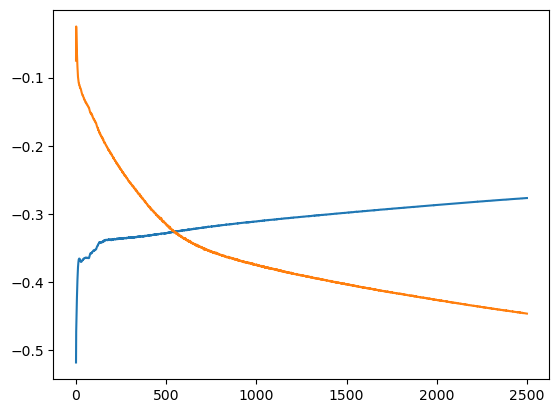

In [17]:
wgan = WGAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.1)

loss_list = []
# Train the GAN
for i in range(20):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        loss_list.append(loss)
    #print(f"Epoch {i}, Discriminator loss: {d_loss}")

plt.plot(loss_list)

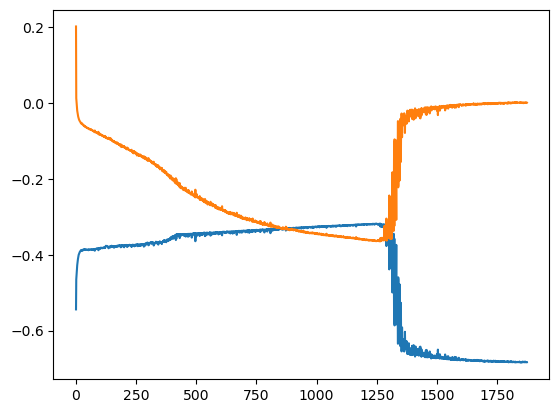

In [19]:
wgan = WGAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.1)

loss_list = []
for i in range(10):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        loss_list.append(loss)

for i in range(5):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        loss = wgan.train_generator(signal_tensor, params_tensor, z)
        loss_list.append(loss)
    #print(f"Epoch {i}, Discriminator loss: {g_loss}")

plt.plot(loss_list)

Epoch 1/100, Generator loss: -0.34256428480148315, Discriminator loss: -0.09197455644607544
Epoch 2/100, Generator loss: -0.3466172218322754, Discriminator loss: -0.09560561180114746
Epoch 3/100, Generator loss: -0.339351624250412, Discriminator loss: -0.09797155857086182
Epoch 4/100, Generator loss: -0.3465919494628906, Discriminator loss: -0.09279689192771912
Epoch 5/100, Generator loss: -0.34340202808380127, Discriminator loss: -0.09832179546356201
Epoch 6/100, Generator loss: -0.34484654664993286, Discriminator loss: -0.09884849190711975
Epoch 7/100, Generator loss: -0.35106468200683594, Discriminator loss: -0.0971750020980835
Epoch 8/100, Generator loss: -0.3629564344882965, Discriminator loss: -0.09819874167442322
Epoch 9/100, Generator loss: -0.38816720247268677, Discriminator loss: -0.08892309665679932
Epoch 10/100, Generator loss: -0.4063527584075928, Discriminator loss: -0.09765380620956421
Epoch 11/100, Generator loss: -0.4004230499267578, Discriminator loss: -0.100268006324

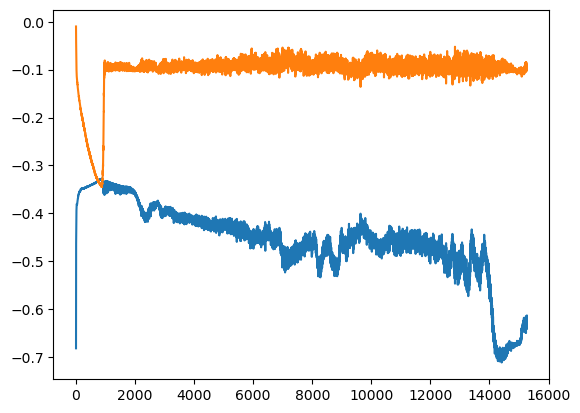

In [12]:
wgan = WGAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.1)

loss_list = []

d_loss_threshold = -0.1
g_loss_threshold = -0.5

num_epochs = 300

for i in range(7):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        loss_list.append(loss) 

for epoch in range(num_epochs):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        signal_tensor = signal_tensor.to(device)
        params_tensor = params_tensor.to(device)
        
        if loss_list[-1][1] < d_loss_threshold:
            loss = wgan.train_generator(signal_tensor, params_tensor, z)
            loss_list.append(loss)

        if loss_list[-1][1] >= g_loss_threshold:
            loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
            loss_list.append(loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Generator loss: {loss[0]}, Discriminator loss: {loss[1]}")

plt.plot(loss_list)

In [74]:
for i in range(10):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):

        loss = wgan.train_generator(signal_tensor, params_tensor, z)
        loss_list.append(loss)

In [79]:
for i in range(20):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):

        loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        loss_list.append(loss)

In [63]:
generator = wgan.generator
generator.eval()

generated_params_list = []

TS = Signal_Generator(num_sources=1, noise_amplitude=1)
test_data = TS.generating_signal()
params = TS.printing_parameters()

input_signal = test_data['Signal'].values
input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

for i in range(10000):
    with torch.no_grad():
        #z = torch.randn(1, num_latent_variables, 1).to(device)
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    generated_params_list.append(generated_params)

In [56]:
generated_params_list

[array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39

Removed no burn in


MCSamplesError: Parameter range is <= 0: omega

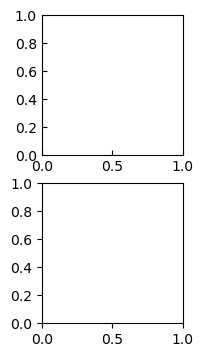

In [57]:
generated_params_df = pd.DataFrame(generated_params_list, columns=['Amplitude', 'Frequency', 'Phase'])


names = ["A","omega","theta"]
labels =  ["Amplitude","frequency","phase"]

generated_params_samples = MCSamples(samples=generated_params_df.values, names=names, labels=labels)
#samples.setRanges([[-3,3],[-3,3]])
generated_params_samples.updateSettings({'fine_bins_2D': 1048})

g = plots.get_subplot_plotter()

g.triangle_plot([generated_params_samples], filled=True)

axes = g.subplots

for i in range(len(names)):
    for j in range(i+1, len(names)):
        ax = axes[j, i]
        if ax is not None:
            ax.scatter(params[i], params[j], color='red', marker='o', s=50)

for i in range(len(names)):
    ax = axes[i, i]
    if ax is not None:
        ax.axvline(params[i], linestyle='--', color='red', lw=1)

handles = [plt.Line2D([0], [0], color='red', lw=2, linestyle='--', marker='o')]
labels = ['Original Parameters']
g.fig.legend(handles, labels, loc='upper right')

plt.show()
#g.export('weight_clip_0.1for300epochs.png')

In [58]:
params

[5.0617646027242085, 0.4330044991527408, 5.963279416988924]

In [59]:
generated_params_list

[array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39709324, 4.7922955 ], dtype=float32),
 array([6.2419133 , 0.39

In [81]:
generator = wgan.generator
generator.eval()

params_list = []
generated_params_list = []

for i in range(30):
    TS = Signal_Generator(num_sources=1, noise_amplitude=1)
    test_data = TS.generating_signal()
    params = TS.printing_parameters()

    input_signal = test_data['Signal'].values
    input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        #z = torch.randn(1, num_latent_variables, 1).to(device)
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    params_list.append(params)
    generated_params_list.append(generated_params)

    print(params)
    print(generated_params)

[11.529156150763729, 0.2562004896006071, 2.071199431196082]
[10.134       0.28595832  2.172121  ]
[7.549748998223492, 0.4409228001435743, 5.855683344709332]
[7.40051    0.38051233 6.60988   ]
[12.370212100223588, 0.3198910198558547, 5.418290612071909]
[10.613746   0.3124809  6.038706 ]
[8.954330178747218, 0.29671954635681724, 3.1382499669116886]
[8.396693   0.31687418 3.5597582 ]
[7.597950538503769, 0.24498205513215543, 5.91052754884525]
[7.3124804  0.27698925 6.178079  ]
[10.778863453401136, 0.24879939907076376, 2.4593332585554033]
[9.164827   0.26718518 2.8550775 ]
[9.702749540582957, 0.3684888958336176, 6.041585925022912]
[8.761544  0.3347773 5.7220287]
[10.889792680284744, 0.19696838662490024, 1.2434132654975463]
[9.335822   0.25844577 1.5604506 ]
[11.005143953687623, 0.27469747109208087, 3.0345289039600525]
[9.154417   0.28881505 3.8230333 ]
[12.761030539835755, 0.25291505851543067, 0.0983764291346748]
[11.443666    0.26707372  1.0817101 ]
[12.324066962179677, 0.3282738849731013, 

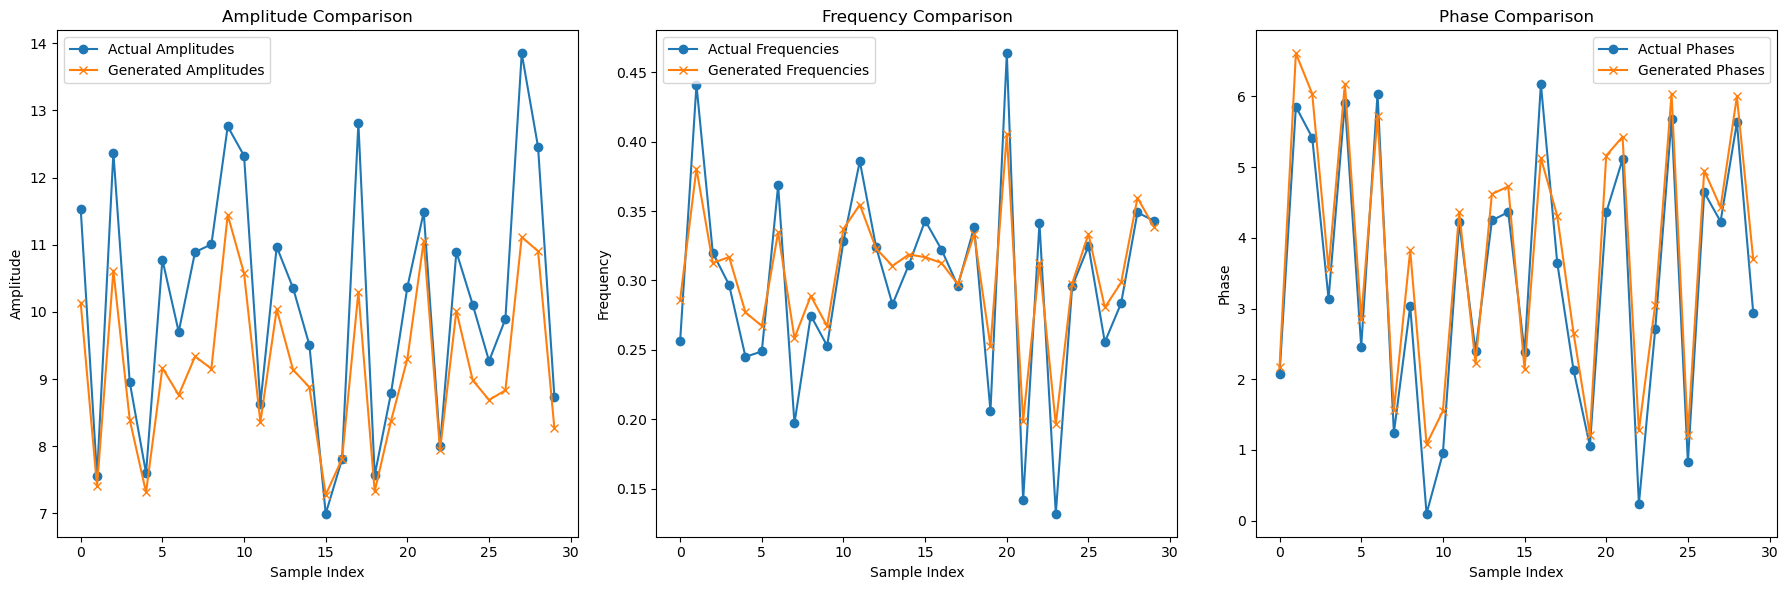

In [82]:
actual_amplitudes = [params[0] for params in params_list]
actual_frequencies = [params[1] for params in params_list]
actual_phases = [params[2] for params in params_list]

generated_amplitudes = [gen_params[0] for gen_params in generated_params_list]
generated_frequencies = [gen_params[1] for gen_params in generated_params_list]
generated_phases = [gen_params[2] for gen_params in generated_params_list]

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(range(30), actual_amplitudes, 'o-', label='Actual Amplitudes')
plt.plot(range(30), generated_amplitudes, 'x-', label='Generated Amplitudes')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Amplitude Comparison')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(30), actual_frequencies, 'o-', label='Actual Frequencies')
plt.plot(range(30), generated_frequencies, 'x-', label='Generated Frequencies')
plt.xlabel('Sample Index')
plt.ylabel('Frequency')
plt.title('Frequency Comparison')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(30), actual_phases, 'o-', label='Actual Phases')
plt.plot(range(30), generated_phases, 'x-', label='Generated Phases')
plt.xlabel('Sample Index')
plt.ylabel('Phase')
plt.title('Phase Comparison')
plt.legend()

plt.tight_layout()
plt.show()
